
# Prediction of cryptocurrency prices using LSTM, SVM and polynomial regression


## Librairies

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import yfinance as yf
import torch
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
import matplotlib.dates as mdates
from datetime import date

## Visualization de la data

[*********************100%%**********************]  1 of 1 completed

C:\Users\Titouan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\yfinance\utils.py:788: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


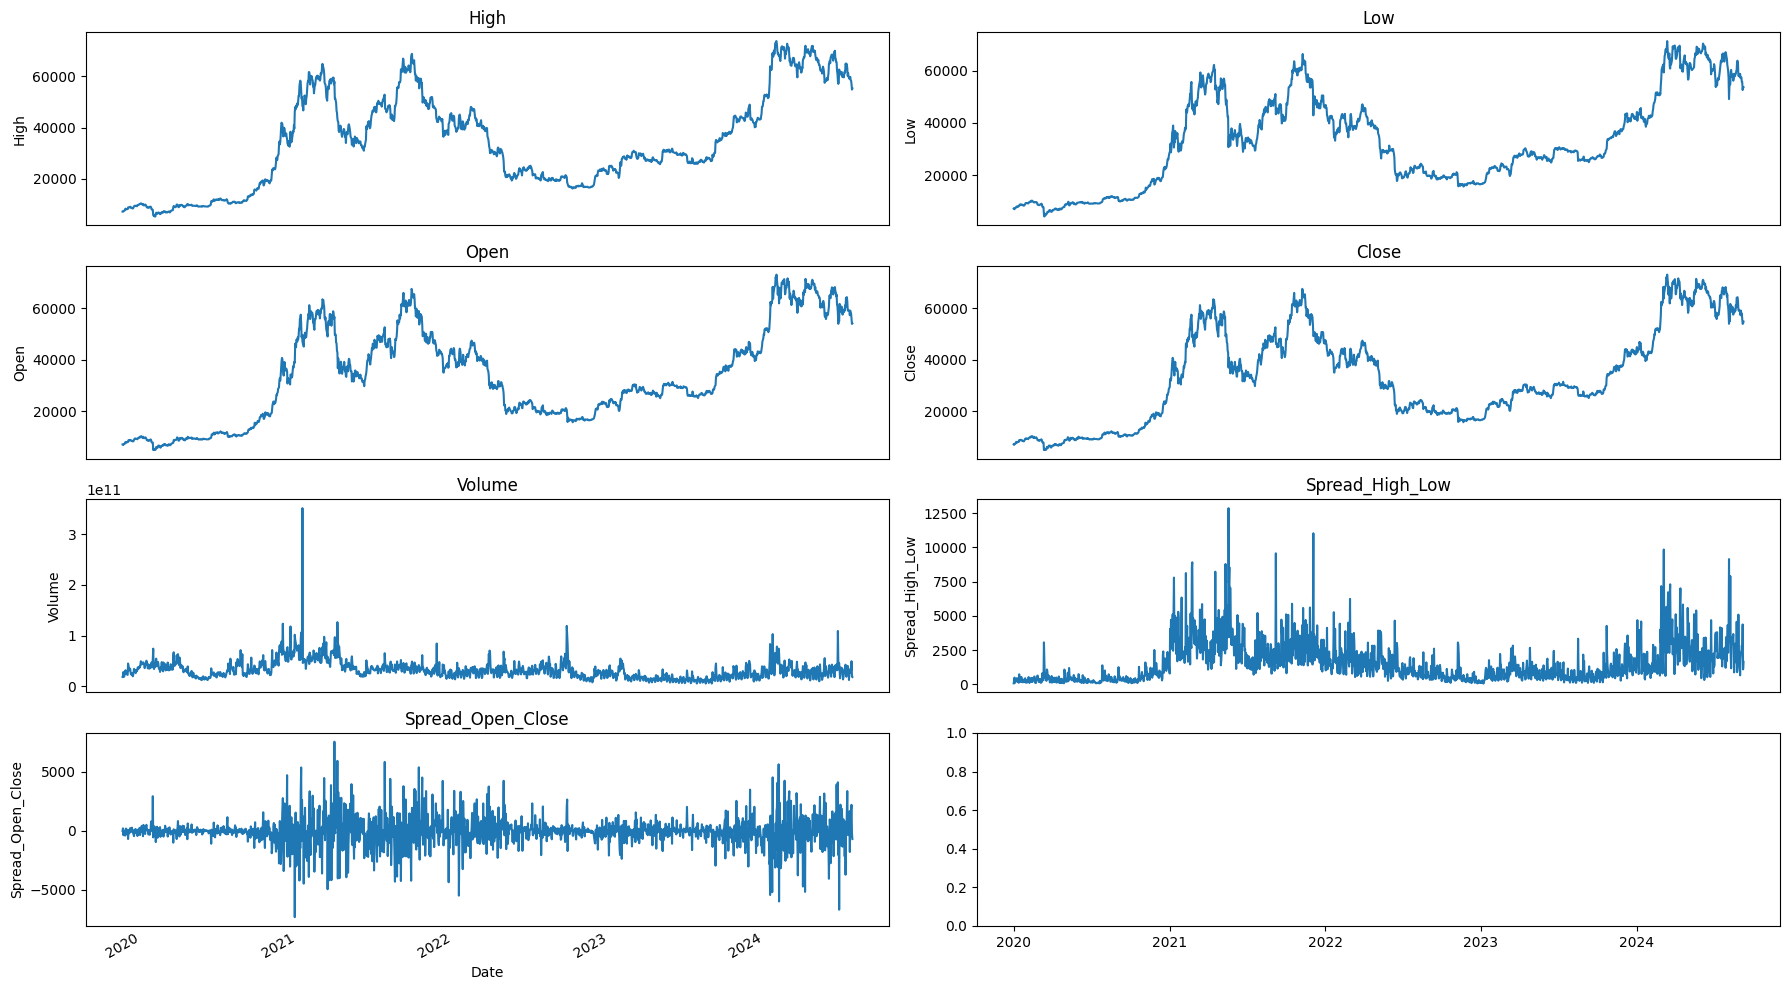

In [2]:
# Step 1: importation des données via yahoo finance
today = date.today() # importation des data jusqu'a aujourd'hui
df = yf.download('BTC-USD', start='2020-01-01', end=today) # on importe prix BTC-USD
df.drop(columns=['Adj Close'], inplace=True) # même colonne que close donc drop
# df
#print(sum(df.isnull().sum()))
df.dropna(inplace=True)
#df
# pas d'élément nuls -> ok


def data_plot(df):

    df['Spread_High_Low'] = df['High'] - df['Low']
    df['Spread_Open_Close'] = df['Open'] - df['Close']

    # colonne du df qu'on veut plot
    df_plot = df[['High', 'Low', 'Open', 'Close', 'Volume', 'Spread_High_Low', 'Spread_Open_Close']]
    # colonne du dataframe qu'on veut plot
    #df_plot = df.iloc[:, 1:]  # on prend après les dates

    # params pour plot
    ncols = 2
    nrows = int(np.ceil(df_plot.shape[1] / ncols))
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(18, 10))

    # bouclee pour tracer chaque colonne
    for i in range(len(df_plot.columns)):
        col_name = df_plot.columns[i]
        sns.lineplot(data=df_plot.iloc[:, i], ax=ax.flat[i])
        ax.flat[i].set_title(col_name)
        ax.flat[i].tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.flat[i].xaxis.set_major_locator(mdates.AutoDateLocator())

    fig.tight_layout()
    plt.show()

data_plot(df)
# Analyse du 'close', les courbes sont similaires ca le bitcoin est une cryptomonnaie liquide -> logique
# on va travailler sur les datas precedentes du close pour déterminer les valeurs futures du close -> prédiction
# prix di BTC qui a atteint son maximum durant le début de l'année 2024

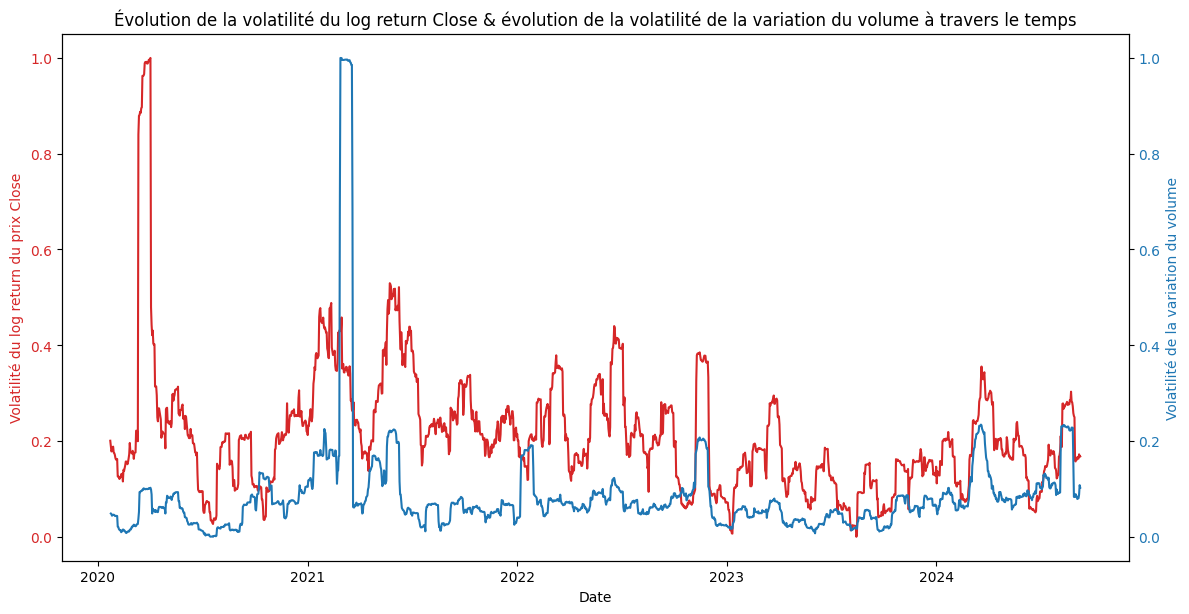

In [3]:

# fonction pour analyser la volatilité du log return du 'close' et la volatiltié du chhangement de volume quotidien
def plot_close_and_change_of_volume(df):

    # calcul des 'log returns' sur le prix 'close'
    df['Log_Return'] = np.log(df['Close'] / df['Close'].shift(1))
    df.dropna(inplace=True)

    # calcul de la volatilité des prix sur une fenêtre de 1 mois (22 jours)
    window_size = 22
    df['Volatility_price'] = df['Log_Return'].rolling(window=window_size).std() * np.sqrt(252)


    # variation de volume
    df['Volume_Change'] = df['Volume'] - df['Volume'].shift(1)
    #df['Volume_Change'] = np.log(df['Volume'] / df['Volume'].shift(1))
    # calcul de la volatilité du changement quotidien du volume sur une fenêtre de 1 mois (22 jours)
    df['Volatility_volume_change'] = df['Volume_Change'].rolling(window=window_size).std() * np.sqrt(252)

    # normalisze pour avoir une meilleure "vue" des courbes
    scaler = MinMaxScaler()
    df[['Volatility_price', 'Volatility_volume_change']] = scaler.fit_transform(df[['Volatility_price', 'Volatility_volume_change']])

    # plot volatilité du log return du close et variation du volume
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # params vol log return 'close' price
    color = 'tab:red'
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Volatilité du log return du prix Close', color=color)
    ax1.plot(df.index, df['Volatility_price'], color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax2 = ax1.twinx()

    # params vol différence quotidienne volume
    color = 'tab:blue'
    ax2.set_ylabel('Volatilité de la variation du volume', color=color)
    ax2.plot(df.index, df['Volatility_volume_change'], color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    # color = 'tab:green'
    # ax2.set_ylabel('Volume', color=color)
    # ax2.plot(df.index, df['Volume'], color=color)
    # ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()
    plt.title("Évolution de la volatilité du log return Close & évolution de la volatilité de la variation du volume à travers le temps")
    plt.show()

plot_close_and_change_of_volume(df)

## Modèles

### LSTM

C:\Users\Titouan\AppData\Local\Temp\ipykernel_71924\3057773195.py:19: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:278.)
  return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
C:\Users\Titouan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([340])) that is different to the input size (torch.Size([340, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch	MSE
10	0.60747701
30	0.14311640
50	0.07175992
80	0.08794315
100	0.08296738


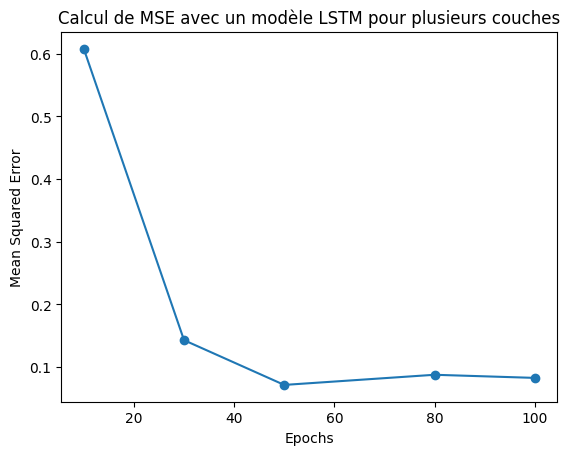

La MSE minimum sur le modèle LSTM est de: 0.07175992 atteinte sur la couche 50


In [4]:

# normalisation des données 'Close' en utilisant MinMaxScaler & les convertir en float32 pour torch.tensor
scaler = MinMaxScaler()
df[['Close']] = scaler.fit_transform(df[['Close']]).reshape(-1,1)
close_price = df['Close'].values.astype('float32')

# séparation de la série temporelle en ensembles d'entraînement et de test (80%/20%)
train_size = int(len(close_price) * 0.8)
test_size = len(close_price) - train_size
train, test = close_price[:train_size], close_price[train_size:]

# création d'un dataset pour la prédiction, avec une fenêtre glissante (lookback) qui utilise torch.tensor pour la classe LSTM
def create_dataset(dataset, lookback):
    X, y = [], []
    for i in range(len(dataset) - lookback):
        feature = dataset[i:(i + lookback)]
        target = dataset[i + lookback]
        X.append(feature)
        y.append(target)
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# modèle LSTM pour prédire les valeurs du prix close


class LSTMModel(torch.nn.Module):

    # init
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.lstm = torch.nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(1, x.size(0), self.hidden_dim).to(x.device)

        out, _ = self.lstm(x, (h0, c0))

        # output
        out = self.fc(out[:, -1, :])
        return out

# params du modèle
input_dim = 1  # une seule caractéristique, le close
hidden_dim = 50
output_dim = 1 # une sortie par définition

# appel du modèle LSTM
model = LSTMModel(input_dim, hidden_dim, output_dim)

# calcul de la fonction de perte et de l'optimiseur vu dans le papier -> MSE & Adam
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Un petit learning rate pour éviter l'overfitting, si lr = 1 : ovefitting

# on va maintenant voir les input via la fonction du dessous qui utulisait torch.tensor
lookback = 3  # utilisation des trois dernières valeurs pour prédire la prochaine
X_train, y_train = create_dataset(train, lookback)
X_test, y_test = create_dataset(test, lookback)

# conversion des données pour le modèle LSTM
X_train = X_train.view(-1, lookback, 1)
X_test = X_test.view(-1, lookback, 1)

# liste des couches sur lesquels on va travailler pour l'entrainement (comme dans le papier)
epochs_list = [10, 30, 50, 80, 100]
mse_results = []

# entraînement du modèle
for epoch in epochs_list:
    for i in range(epoch):
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train.view(-1, 1))
        loss.backward()
        optimizer.step()
    # Éevvaluation du modèle
    with torch.no_grad():
        # evaluation du modele après l'entraiinement
        outputs = model(X_test)
        mse = criterion(outputs, y_test)
        mse_results.append(mse.item())

# on print les résultats MSE pour chaque epoch
print("Epoch\tMSE")
for i, mse in enumerate(mse_results):
    print(f"{epochs_list[i]}\t{mse:.8f}")

# on trouve maintenant l'epoch avec le MSE minimum (pour couche 30, comme dans le papier -> ok)
min_mse_LSTM = min(mse_results)
min_epoch_LSTM = epochs_list[mse_results.index(min_mse_LSTM)]

# on afficche les résultats
plt.plot(epochs_list, mse_results, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.title('Calcul de MSE avec un modèle LSTM pour plusieurs couches')
plt.show()

# affiche résultat souhaité, i.e la MSE minimale et l'epoch correspondant
print(f"La MSE minimum sur le modèle LSTM est de: {min_mse_LSTM:.8f} atteinte sur la couche {min_epoch_LSTM}")

# Comme dans le papier, on voit bien que la valeur minimale de MSE est atteinte pour la couche 30, que ça baisse entre 10 et 30 pour ensuite remonter entre 30 et 50 puis baisser de 80 à 100 comme dans le papier.
# La MSE est aussi la plus élevée pour la couche 10.
# On peut voir que les valeurs sont bien différentes de celle du papier.
# Après plusieurs tests, on est arrivé à la conclusion qu'ils avaient possiblement sommé les MSE daily, ce que nous avons préféré ne pas faire dans notre cas (pas forcément de sens ?)
# En effet, si on prend couche = 30, alors 0.08 * 1640 ~ 130 donc proche de leur valeur
# same pour les autres valeurs

### SVM

[*********************100%%**********************]  1 of 1 completed

C:\Users\Titouan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\yfinance\utils.py:788: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')



Meilleurs paramètres pour modele SVM:  {'C': 100, 'gamma': 0.1, 'kernel': 'sigmoid'}
Modèle SVM : MSE avec les meilleurs params:  0.001032293088675588


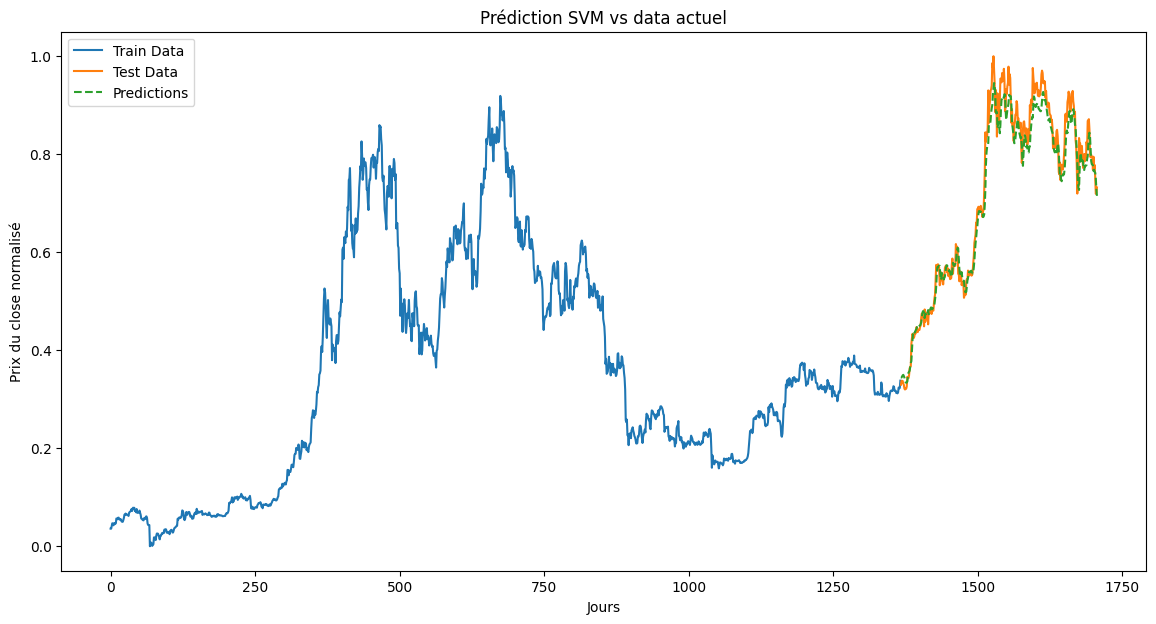

Tableau des MSE avec le modèle SVM pour chaque ensemble de paramètres:
   param_kernel param_C param_gamma  mean_test_score
0        linear       1       0.001     1.274701e-03
12       linear      10       0.001     1.071173e-03
24       linear     100       0.001     1.071173e-03
36       linear    1000       0.001     1.071173e-03
3        linear       1        0.01     1.274701e-03
15       linear      10        0.01     1.071173e-03
27       linear     100        0.01     1.071173e-03
39       linear    1000        0.01     1.071173e-03
6        linear       1         0.1     1.274701e-03
18       linear      10         0.1     1.071173e-03
30       linear     100         0.1     1.071173e-03
42       linear    1000         0.1     1.071173e-03
9        linear       1           1     1.274701e-03
21       linear      10           1     1.071173e-03
33       linear     100           1     1.071173e-03
45       linear    1000           1     1.071173e-03
1           rbf       1     

C:\Users\Titouan\AppData\Local\Temp\ipykernel_71924\2001866871.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mse_results['mean_test_score'] = -mse_results['mean_test_score']  # convertir les scores négatifs en MSE car scoring = "neg_mean_squared_error" d'ou le -


In [5]:

# importation data
today = date.today()
df = yf.download('BTC-USD', start='2020-01-01', end=today)

# nroamlkise data close
scaler = MinMaxScaler()
close_price_SVM = scaler.fit_transform(df[['Close']]).reshape(-1,1)

# séparation des échantillons en train et test (80%/20%)
train_size = int(len(close_price_SVM) * 0.8)
test_size = len(close_price_SVM) - train_size
train, test = close_price_SVM[:train_size], close_price_SVM[train_size:]

# création d'un dataset pour la prédiction, avec une fenêtre glissante (lookback),  pour creer des array utiles dans le modele SVM (different de tout à l'heure ) np.array != torch.tensor
def create_features(data, lookback):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

lookback = 3  # utilisation des trois dernières valeurs pour prédire la prochaine
X_train, y_train = create_features(train, lookback)
X_test, y_test = create_features(test, lookback)

# paramètres du papier
param_grid = {
    'kernel': ['linear', 'rbf', 'sigmoid'],
    'C': [1, 10, 100,1000],
    'gamma': [0.001, 0.01, 0.1, 1]
}

# modele SVR
svr = SVR()

# on utilise GridSearchCV pour trouver les meilleurs hyperparamètres du modèle
grid_search = GridSearchCV(estimator=svr, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# recuperer les meilleurs paramètres
best_params = grid_search.best_params_
print("Meilleurs paramètres pour modele SVM: ", best_params)

# modele SVR avec les meulleurs params sur le dataset d'entrainement
best_svr = SVR(kernel=best_params['kernel'], C=best_params['C'], gamma=best_params['gamma'])
best_svr.fit(X_train, y_train)

# predict sur le test
y_pred = best_svr.predict(X_test)

# calcule MSE
min_mse_SVM = mean_squared_error(y_test, y_pred)
print("Modèle SVM : MSE avec les meilleurs params: ", min_mse_SVM)

# plot le résultat
plt.figure(figsize=(14, 7))
plt.plot(range(len(y_train)), y_train, label='Train Data')
plt.plot(range(len(y_train), len(y_train) + len(y_test)), y_test, label='Test Data')
plt.plot(range(len(y_train), len(y_train) + len(y_test)), y_pred, label='Predictions', linestyle='dashed')
plt.xlabel('Jours')
plt.ylabel('Prix du close normalisé')
plt.title('Prédiction SVM vs data actuel')
plt.legend()
plt.show()


# Contrairement au papier nos meilleurs parametres sont C=100 (contre 1000)
# kernel : sigmoid (contre linéaire), mais le même Gamma.
# La MSE est bien inférieure à celle du papier, conformément à notre
# remarque faite dans le modèle LSTM

# calcul des MSE pour chaque combinaison de paramètres
results = pd.DataFrame(grid_search.cv_results_)
mse_results = results[['param_kernel', 'param_C', 'param_gamma', 'mean_test_score']]
mse_results['mean_test_score'] = -mse_results['mean_test_score']  # convertir les scores négatifs en MSE car scoring = "neg_mean_squared_error" d'ou le -

# trier par kernel, puis gamma, puis C (visualisation plus simple comme dans le papier)
mse_results_sorted = mse_results.sort_values(by=['param_kernel', 'param_gamma', 'param_C'])

# tableau trié
print("Tableau des MSE avec le modèle SVM pour chaque ensemble de paramètres:")
print(mse_results_sorted)


# Les MSE les plus faibles sont obtenues avec le kernel Sigmoid pour
# C=1000 avec Gamma =0.1 et Gamma = 0.01. Dans l'article c'est le kernel
# Linéaire qui performe le mieux

### Polynomial regression

[*********************100%%**********************]  1 of 1 completed
Degree	MSE
2	0.05
4	0.02
6	0.01
9	0.04
11	0.04


C:\Users\Titouan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\yfinance\utils.py:788: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


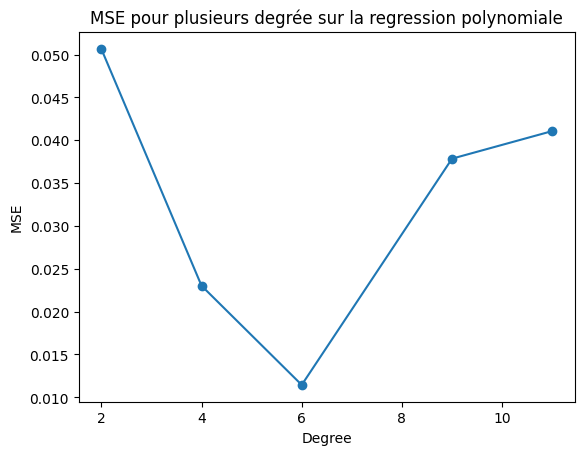

La MSE minimum sur la regression polynomial est de: 0.01144418 atteinte sur le degré 6


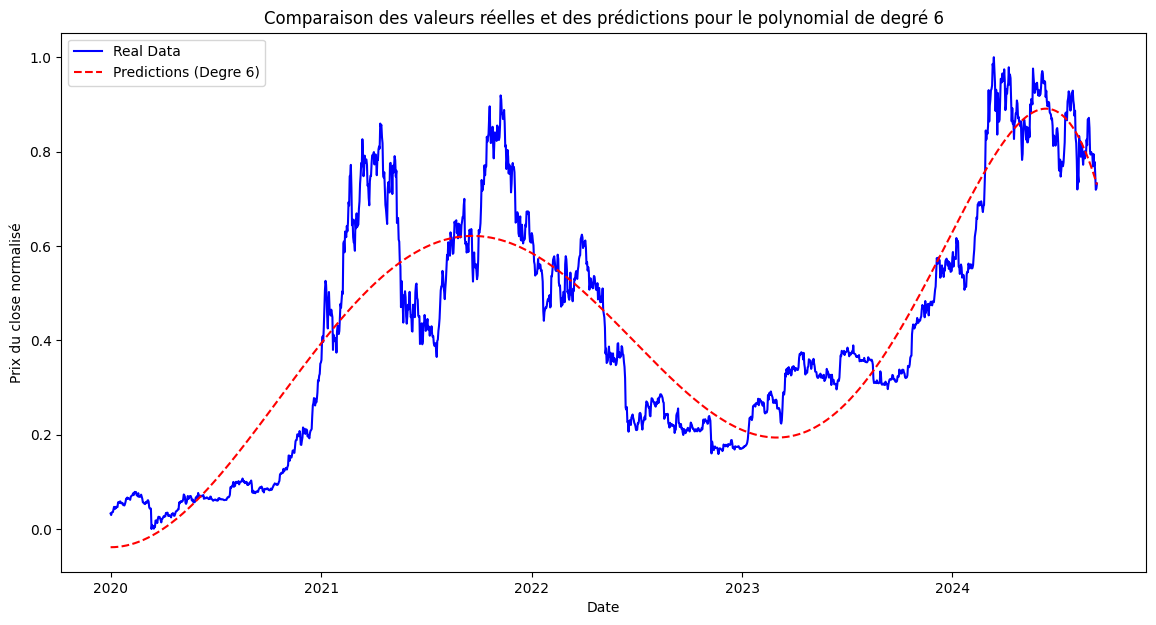

In [6]:

# on reimporte les data
today = date.today()
df = yf.download('BTC-USD', start='2020-01-01', end=today)

# check les NaN -> OK
#print(df.isnull().sum())

# normalise les datas
scaler = MinMaxScaler()
df[['Open', 'High', 'Low', 'Close', 'Volume']] = scaler.fit_transform(df[['Open', 'High', 'Low', 'Close', 'Volume']])


# les degrés de la régression polynomiale souhaites (comme dans le papier)
degrees = [2, 4, 6, 9, 11]
results_polynomial_regression = []

# régression polynomiale pour différents degrés
for degree in degrees:
    X = np.arange(len(df)).reshape(-1, 1)  # date comme X
    y = df['Close'].values  # close comme y ( variable cible)

    # transo polynomiale de degrees = degree
    poly_reg = PolynomialFeatures(degree=degree)
    X_poly = poly_reg.fit_transform(X)

    # regression linéaire en utilisant fit et predict
    lin_reg = LinearRegression()
    lin_reg.fit(X_poly, y)
    y_pred = lin_reg.predict(X_poly)

    # calcul de la MSE
    mse = mean_squared_error(y, y_pred)
    results_polynomial_regression.append((degree, mse))

# les résultats de MSE pour chaque degre
print("Degree\tMSE")
for degree, mse in results_polynomial_regression:
    print(f"{degree}\t{mse:.2f}")

# plot graph - resultats pour comparaisons
degrees, mses = zip(*results_polynomial_regression)
plt.plot(degrees, mses, marker='o')
plt.xlabel('Degree')
plt.ylabel('MSE')
plt.title('MSE pour plusieurs degrée sur la regression polynomiale')
plt.show()


min_mse_value = min(results_polynomial_regression, key=lambda x: x[1])
min_degree_polynomial_regression,min_mse_polynomial_regression = min_mse_value

print(f"La MSE minimum sur la regression polynomial est de: {min_mse_polynomial_regression:.8f} atteinte sur le degré {min_degree_polynomial_regression}")


# commentaires analysant les résultats
# comme dans le papier, on a bien les valeurs atteint sur les degrés 4 et 6 qui sont bien plus faibles que les
# valeurs des degrés 2, 9 et 11. Cependant, chez nous la valeur sur le deuxième degré est supérieur aux valeurs
# pour les degrés 9 et 11. Mais ces 3 valeurs sont bien, voire nettement supérieures aux valeurs des degrés 4 et 6 -> ressemblance avec les resultats du papier

# Selection du meilleur degré et entrainement pour le plot des prédictions
best_degree = min_degree_polynomial_regression
poly_reg_best = PolynomialFeatures(degree=best_degree)
X_poly_best = poly_reg_best.fit_transform(X)

lin_reg_best = LinearRegression()
lin_reg_best.fit(X_poly_best, y)
y_pred_best = lin_reg_best.predict(X_poly_best)

# Plot des prédictions
plt.figure(figsize=(14, 7))
plt.plot(df.index, y, label='Real Data', color='blue')
plt.plot(df.index, y_pred_best, label=f'Predictions (Degre {best_degree})', color='red', linestyle='dashed')
plt.title(f'Comparaison des valeurs réelles et des prédictions pour le polynomial de degré {best_degree}')
plt.xlabel('Date')
plt.ylabel('Prix du close normalisé')
plt.legend()
plt.show()

## Conclusion

In [7]:

# list resultat avec MSE minimal et modele corrzspondant
list_resultat_final = [("LSTM", min_mse_LSTM), ("SVM", min_mse_SVM), ("Polynomial Regression", min_mse_polynomial_regression)]
resultat_final = min(list_resultat_final, key=lambda x: x[1])
model_name, min_mse_value = resultat_final


print(f"La plus petite MSE est {min_mse_value:.8f} et elle correspond au modèle {model_name}.")

# on a bien retrouvé les résultats du papier, c'est à dire avec une MSE minimale atteint avec le modele SVM
# on a trouvé des valeurs bien inférieures à celle du papier originel
# on pense qu'ils ont sommé les MSE daily pour trouver des valeurs aussi grandes sur certains modeles (parfois des MSE a plusieurs milliards)

# c'est le modele SVM avec un kernel sigmoid et des parametres C=100 avec Gamma =0.1  qui a montré 
# la meilleure performance en termes de MSE.

# le DL peut être efficacement appliqué à prédiction des marchés de cryptos, malgré une volatilité importante.

# Une des principales limites est qu'on utilise qu'un type de données (prix de clôture) alors que l'intégration de d'autres types de données
# (choc exogène, annonce, indicateurs écos...) pourrait améliorer précision des prédictions.
# Cela pourrait donc etre interessant de les integrer dans de prochaines etudes.

La plus petite MSE est 0.00103229 et elle correspond au modèle SVM.
